# **Analisis Prediksi NO2 Menggunakan KNN Regression**

### **1. Pengambilan Data (Scraping)**

Data diambil dari sumber Dataspace Coneous yang menyediakan informasi cuaca dan kualitas udara. Scraping dilakukan untuk daerah **Surakarta** dan mengambil **periode 1 tahun penuh**, dengan mengambil variabel utama yaitu konsentrasi NO2 per hari.

Data mentah memiliki beberapa kolom, namun untuk keperluan analisis, hanya kolom NO2 dan tanggal (date) yang digunakan.

Authenticated using refresh token.
0:00:00 Job 'j-25102307552043458de4cbce5b2f0d05': send 'start'
0:00:13 Job 'j-25102307552043458de4cbce5b2f0d05': created (progress 0%)
0:00:19 Job 'j-25102307552043458de4cbce5b2f0d05': created (progress 0%)
0:00:25 Job 'j-25102307552043458de4cbce5b2f0d05': created (progress 0%)
0:00:34 Job 'j-25102307552043458de4cbce5b2f0d05': created (progress 0%)
0:00:44 Job 'j-25102307552043458de4cbce5b2f0d05': created (progress 0%)
0:00:56 Job 'j-25102307552043458de4cbce5b2f0d05': running (progress N/A)
0:01:12 Job 'j-25102307552043458de4cbce5b2f0d05': running (progress N/A)
0:01:31 Job 'j-25102307552043458de4cbce5b2f0d05': running (progress N/A)
0:01:56 Job 'j-25102307552043458de4cbce5b2f0d05': running (progress N/A)
0:02:26 Job 'j-25102307552043458de4cbce5b2f0d05': running (progress N/A)
0:03:03 Job 'j-25102307552043458de4cbce5b2f0d05': running (progress N/A)
0:03:50 Job 'j-25102307552043458de4cbce5b2f0d05': running (progress N/A)
0:04:49 Job 'j-2510230755204345

/tmp/ipython-input-3794286045.py:67: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["date"].dt.to_period("M")


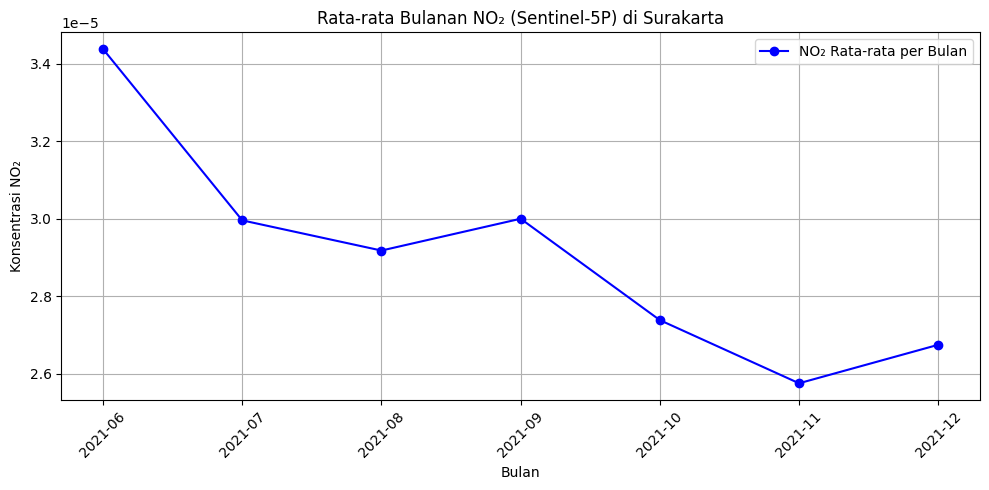

In [ ]:
!pip install openeo
import openeo
import pandas as pd
import matplotlib.pyplot as plt

# 1. Koneksi ke Copernicus Data Space
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

# 2. AOI: poligon kedua dari data kamu
aoi = {
    "type": "Polygon",
    "coordinates": [
          [
            [110.73384843270605, -7.506125504050544],
            [110.73384843270605, -7.629910709610229],
            [110.93095130302544, -7.629910709610229],
            [110.93095130302544, -7.506125504050544],
            [110.73384843270605, -7.506125504050544]
          ]
        ],
}

# 3. Ambil data Sentinel-5P (band "NO2")
s5p = connection.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent = {
    "west": 110.73384843270605,
    "south": -7.629910709610229,
    "east": 110.93095130302544,
    "north": -7.506125504050544
},
    temporal_extent=["2021-06-01", "2021-12-30"],
    bands=["NO2"],
)

# 4. Mask nilai negatif (data invalid)
def mask_invalid(x):
    return x < 0

s5p_masked = s5p.mask(s5p.apply(mask_invalid))

# 5. Agregasi temporal harian
daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

# 6. Agregasi spasial (rata-rata dalam AOI)
daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi, reducer="mean")

# 7. Jalankan batch job dan hasilkan file CSV
job = daily_mean_aoi.execute_batch(out_format="CSV")

# 8. Unduh hasil job
results = job.get_results()
results.download_files("Surakarta")

# 9. Baca file CSV hasil
import os
for f in os.listdir("Surakarta"):
    if f.endswith(".csv"):
        df = pd.read_csv(os.path.join("Surakarta", f))
        print("File ditemukan:", f)
        break

# 10. Pastikan kolom tanggal benar
df["date"] = pd.to_datetime(df["date"])

# 11. Buat kolom bulan (YYYY-MM)
df["month"] = df["date"].dt.to_period("M")

# 12. Hitung rata-rata NO2 per bulan
df_monthly = df.groupby("month", as_index=False)["NO2"].mean()

# 13. Visualisasi hasil
plt.figure(figsize=(10,5))
plt.plot(df_monthly["month"].astype(str), df_monthly["NO2"], marker="o", color="blue", label="NO‚ÇÇ Rata-rata per Bulan")
plt.title("Rata-rata Bulanan NO‚ÇÇ (Sentinel-5P) di Surakarta")
plt.xlabel("Bulan")
plt.ylabel("Konsentrasi NO‚ÇÇ")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving surakarta.csv to surakarta.csv


In [ ]:
import pandas as pd

# Baca file CSV
df = pd.read_csv("surakarta.csv", sep=';')

print(df.columns)


# Bersihkan kolom NO2
df['NO2'] = (
    df['NO2']
    .replace('', pd.NA)
    .str.replace(',', '.', regex=False)
)

# Ubah ke numerik
df['NO2'] = pd.to_numeric(df['NO2'], errors='coerce')

# Ubah kolom date ke datetime
df['date'] = pd.to_datetime(df['date'], utc=True, errors='coerce')

# Urutkan berdasarkan tanggal
df = df.sort_values(by='date').reset_index(drop=True)

# Tampilkan ringkasan
print(df.info())
print(df.head())


Index(['date', 'feature_index', 'NO2'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   date           395 non-null    datetime64[ns, UTC]
 1   feature_index  395 non-null    int64              
 2   NO2            235 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(1)
memory usage: 9.4 KB
None
                       date  feature_index           NO2
0 2020-05-31 00:00:00+00:00              0           NaN
1 2020-06-01 00:00:00+00:00              0           NaN
2 2020-06-02 00:00:00+00:00              0  3.310000e+10
3 2020-06-03 00:00:00+00:00              0           NaN
4 2020-06-04 00:00:00+00:00              0  2.840000e+11


In [ ]:
df = df.drop(columns=['date', 'feature_index'])
print(df.head(10))

            NO2
0           NaN
1           NaN
2  3.310000e+10
3           NaN
4  2.840000e+11
5  2.870000e+11
6  3.380000e+10
7  2.780000e+10
8  2.910000e+11
9  3.100000e+10


### **3. Pembersihan dan Pra-Pemrosesan Data**

**a. Menangani Missing Values**

Pada dataset yang diunduh, ditemukan beberapa nilai hilang (missing values) di kolom NO2. Untuk menjaga kontinuitas data deret waktu (time series), nilai-nilai hilang diisi menggunakan metode interpolasi linear:

Metode ini memperkirakan nilai di antara dua titik data terdekat, menjaga kestabilan pola data.

In [ ]:
print(df['NO2'].isna().sum())

160


In [ ]:
df['NO2'] = df['NO2'].interpolate(method='linear')

In [ ]:
print(df['NO2'].isna().sum())
df[df['NO2'].isna()]

2


NO2
0  NaN
1  NaN

In [ ]:
df['NO2'] = df['NO2'].interpolate(method='linear').bfill()

In [ ]:
print(df['NO2'].isna().sum())

0


**b. Normalisasi Data**

Agar semua nilai berada dalam rentang yang sama dan mencegah dominasi nilai besar terhadap model, dilakukan normalisasi Min-Max yaitu Normalisasi dengan menghasilkan nilai antara 0 hingga 1.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['NO2_norm'] = scaler.fit_transform(df[['NO2']])

In [ ]:
print(df.head(10))

            NO2  NO2_norm
0  3.310000e+10  0.052405
1  3.310000e+10  0.052405
2  3.310000e+10  0.052405
3  1.585500e+11  0.263589
4  2.840000e+11  0.474774
5  2.870000e+11  0.479824
6  3.380000e+10  0.053583
7  2.780000e+10  0.043483
8  2.910000e+11  0.486558
9  3.100000e+10  0.048870


### **4. Pembentukan Data Supervised**

Karena data NO2 bersifat deret waktu, maka dibentuk data supervised untuk memprediksi nilai ke depan berdasarkan beberapa nilai sebelumnya.

Tiga eksperimen dilakukan dengan variasi jumlah lag:

- Eksperimen 1: Menggunakan 3 lag (NO2-t3, NO2-t2, NO2-t1, NO2)

- Eksperimen 2: Menggunakan 4 lag (NO2-t4, NO2-t3, NO2-t2, NO2-t1, NO2)

- Eksperimen 3: Menggunakan 5 lag (NO2-t5, NO2-t4, NO2-t3, NO2-t2, NO2-t1, NO2)

Tujuannya adalah untuk melihat pengaruh jumlah lag terhadap performa model.

In [ ]:
import pandas as pd

def make_supervised(df, target_col='NO2', n_lags=3):
    """
    Membuat dataset supervised learning dengan lag features.

    Parameters:
      df : DataFrame dengan kolom target (misal 'NO2')
      target_col : nama kolom target
      n_lags : jumlah lag yang ingin digunakan (misal 3 ‚Üí t-1, t-2, t-3)

    Returns:
      DataFrame baru dengan kolom lag + target (tanpa NaN)
    """
    df_supervised = df.copy()
    # Buat kolom lag
    for i in range(1, n_lags + 1):
        df_supervised[f'{target_col}_t-{i}'] = df_supervised[target_col].shift(i)

    # Urutkan kolom biar rapi (lag dulu, target terakhir)
    cols = [f'{target_col}_t-{i}' for i in range(n_lags, 0, -1)] + [target_col]
    df_supervised = df_supervised[cols]

    # Hapus baris dengan NaN (karena hasil shift)
    df_supervised = df_supervised.dropna().reset_index(drop=True)

    return df_supervised

In [ ]:
# Pastikan df hanya punya kolom NO2
df = df[['NO2']].copy().reset_index(drop=True)

# Eksperimen 1: 3 lag
df_exp1 = make_supervised(df, n_lags=3)
print("Eksperimen 1 (3 lag):")
print(df_exp1.head(), "\n")

# Eksperimen 2: 4 lag
df_exp2 = make_supervised(df, n_lags=4)
print("Eksperimen 2 (4 lag):")
print(df_exp2.head(), "\n")

# Eksperimen 3: 5 lag
df_exp3 = make_supervised(df, n_lags=5)
print("Eksperimen 3 (5 lag):")
print(df_exp3.head(), "\n")


Eksperimen 1 (3 lag):
        NO2_t-3       NO2_t-2       NO2_t-1           NO2
0  3.310000e+10  3.310000e+10  3.310000e+10  1.585500e+11
1  3.310000e+10  3.310000e+10  1.585500e+11  2.840000e+11
2  3.310000e+10  1.585500e+11  2.840000e+11  2.870000e+11
3  1.585500e+11  2.840000e+11  2.870000e+11  3.380000e+10
4  2.840000e+11  2.870000e+11  3.380000e+10  2.780000e+10 

Eksperimen 2 (4 lag):
        NO2_t-4       NO2_t-3       NO2_t-2       NO2_t-1           NO2
0  3.310000e+10  3.310000e+10  3.310000e+10  1.585500e+11  2.840000e+11
1  3.310000e+10  3.310000e+10  1.585500e+11  2.840000e+11  2.870000e+11
2  3.310000e+10  1.585500e+11  2.840000e+11  2.870000e+11  3.380000e+10
3  1.585500e+11  2.840000e+11  2.870000e+11  3.380000e+10  2.780000e+10
4  2.840000e+11  2.870000e+11  3.380000e+10  2.780000e+10  2.910000e+11 

Eksperimen 3 (5 lag):
        NO2_t-5       NO2_t-4       NO2_t-3       NO2_t-2       NO2_t-1  \
0  3.310000e+10  3.310000e+10  3.310000e+10  1.585500e+11  2.840000e+11   


### **5. Pembangunan Model KNN Regression**

Untuk setiap eksperimen, digunakan model KNN Regressor dari scikit-learn dengan parameter n_neighbors=3. Model dilatih dengan pembagian data train-test split 80:20 tanpa shuffle karena bersifat time series.

Proses pelatihan dan evaluasi:

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# -------------------------------------------------------
# 1Ô∏è‚É£ Simpan dataset yang sudah kamu buat sebelumnya
# -------------------------------------------------------
datasets = {
    'Exp1 (3 lag)': df_exp1,
    'Exp2 (4 lag)': df_exp2,
    'Exp3 (5 lag)': df_exp3
}

# -------------------------------------------------------
# 2Ô∏è‚É£ Fungsi training & evaluasi model KNN
# -------------------------------------------------------
def train_knn(df_supervised, n_neighbors=3):
    # Normalisasi agar skala NO2 seragam
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_supervised)
    df_scaled = pd.DataFrame(scaled, columns=df_supervised.columns)

    # Pisahkan fitur (lag) dan target (NO2)
    X = df_scaled.drop('NO2', axis=1)
    y = df_scaled['NO2']

    # Split data tanpa shuffle (karena time series)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    # Buat model KNN Regressor
    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)

    # Prediksi
    y_pred = model.predict(X_test)

    # Evaluasi
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    return rmse, r2, y_test, y_pred

### **6. Hasil Evaluasi Model**

Setelah model dilatih untuk tiga eksperimen, diperoleh hasil evaluasi sebagai berikut:

In [ ]:
# -------------------------------------------------------
# 3Ô∏è‚É£ Jalankan untuk ketiga eksperimen
# -------------------------------------------------------
results = []

for name, data in datasets.items():
    rmse, r2, y_test, y_pred = train_knn(data)
    results.append({'Eksperimen': name, 'RMSE': rmse, 'R¬≤': r2})
    print(f"\n=== {name} ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"R¬≤: {r2:.4f}")
    print(pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred}).head(10))

# -------------------------------------------------------
# 4Ô∏è‚É£ Bandingkan hasil
# -------------------------------------------------------
results_df = pd.DataFrame(results)
print("\nüìä Hasil Perbandingan Model KNN Regression:\n")
print(results_df)


=== Exp1 (3 lag) ===
RMSE: 0.2381
R¬≤: 0.0654
     Actual  Predicted
0  0.439422   0.202566
1  0.314513   0.501204
2  0.189603   0.215804
3  0.064694   0.100966
4  0.599347   0.155722
5  0.387236   0.320764
6  0.276916   0.255301
7  0.166597   0.172421
8  0.056277   0.071259
9  0.040621   0.155179

=== Exp2 (4 lag) ===
RMSE: 0.2388
R¬≤: 0.0600
     Actual  Predicted
0  0.439422   0.202566
1  0.314513   0.362789
2  0.189603   0.220349
3  0.064694   0.071259
4  0.599347   0.152916
5  0.387236   0.337463
6  0.276916   0.301146
7  0.166597   0.286299
8  0.056277   0.106736
9  0.040621   0.155179

=== Exp3 (5 lag) ===
RMSE: 0.2609
R¬≤: -0.1140
     Actual  Predicted
0  0.314513   0.360941
1  0.189603   0.282722
2  0.064694   0.143919
3  0.599347   0.155722
4  0.387236   0.163379
5  0.276916   0.408605
6  0.166597   0.170978
7  0.056277   0.235061
8  0.040621   0.041051
9  0.062337   0.053306

üìä Hasil Perbandingan Model KNN Regression:

     Eksperimen      RMSE        R¬≤
0  Exp1 (3 lag

### **7. Visualisasi Perbandingan Model**

Untuk mempermudah interpretasi hasil, dibuat visualisasi perbandingan menggunakan grafik batang:

Sumbu X: Eksperimen (3 lag, 4 lag, 5 lag)

Sumbu Y: Nilai RMSE dan R¬≤

Grafik ini membantu melihat perbedaan performa antar konfigurasi model secara visual.

/tmp/ipython-input-2854695262.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


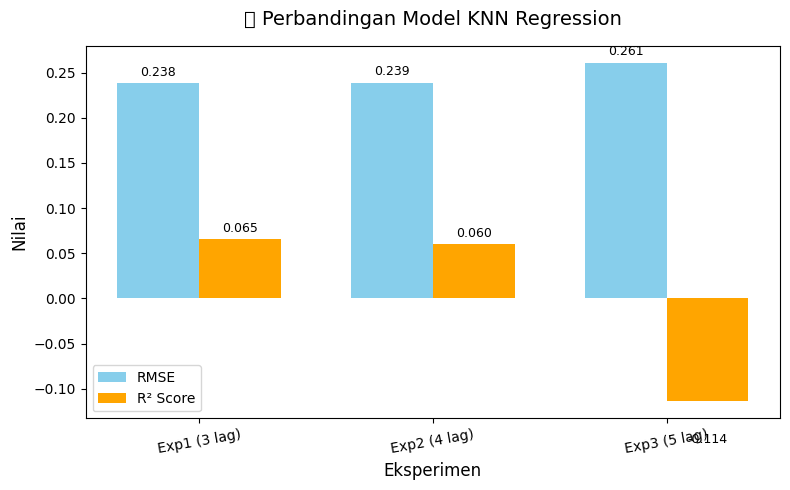

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Visualisasi hasil perbandingan ---
x = np.arange(len(results_df))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))

# Plot batang RMSE & R¬≤ langsung dari results_df
bars1 = ax.bar(x - width/2, results_df['RMSE'], width, label='RMSE', color='skyblue')
bars2 = ax.bar(x + width/2, results_df['R¬≤'], width, label='R¬≤ Score', color='orange')

# Judul & label sumbu
ax.set_title("üìä Perbandingan Model KNN Regression", fontsize=14, pad=15)
ax.set_xlabel("Eksperimen", fontsize=12)
ax.set_ylabel("Nilai", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(results_df['Eksperimen'], rotation=10)
ax.legend()

# Tambahkan nilai di atas batang
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height + 0.005 if height >= 0 else height - 0.05,
            f"{height:.3f}",
            ha='center', va='bottom', fontsize=9
        )

plt.tight_layout()
plt.show()
